# SG2212/SG3114 - Computational fluid dynamics

Template for homework 4

Import some relevant libraries:

In [2]:
# possible options: notebook, inline or widget
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation
import math 
import scipy.sparse as sp
import scipy.linalg as scl
from scipy.sparse.linalg import splu
params = {'legend.fontsize': 12,
          'legend.loc':'best',
          'figure.figsize': (8,5),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':12,
          'ytick.labelsize':12,
          'grid.alpha':0.6}
pylab.rcParams.update(params)
mpl.rcParams['figure.dpi'] = 200

Some useful functions:

In [3]:
def DD(n,h):
    """
    One-dimensional finite-difference derivative matrix 
    of size n times n for second derivative:
    h^2 * f''(x_j) = -f(x_j-1) + 2*f(x_j) - f(x_j+1)

    Homogeneous Neumann boundary conditions on the boundaries 
    are imposed, i.e.
    f(x_0) = f(x_1) 
    if the wall lies between x_0 and x_1. This gives then
    h^2 * f''(x_j) = + f(x_0) - 2*f(x_1) + f(x_2)
                   = + f(x_1) - 2*f(x_1) + f(x_2)
                   =              f(x_1) + f(x_2)

    For n=5 and h=1 the following result is obtained:
 
    A =
        -1     1     0     0     0
         1    -2     1     0     0
         0     1    -2     1     0
         0     0     1    -2     1
         0     0     0     1    -1
    """
    A = (-2 * sp.eye(n, k=0) + sp.eye(n, k=1) + sp.eye(n, k=-1)) # Creates 1 -2 1 pattern along diagonal divided by h^2
    A = sp.csr_array(A) # Convert to different format to allow setting edge cases
    A[0,0] = -1 # Correct corners
    A[-1, -1] = -1
    return A/h/h
    
def GS_SOR(omega, Nx, Ny, hx, hy, L, f, p0, tol, maxit):
    """
    Gauss-Seidel / Successive Over Relaxation method
    for the solution of a scalar Poisson equation
    """
    m=1
    r=np.array([1,])
    b2=(hx/hy)**2
    hx2 = hx**2
    p=np.copy(p0)

    # Define SOR constants (see hand calculations)
    A = omega/(1+b2)
    B = omega/(2+b2)
    C = omega/(1+2*b2)
    D = omega/2/(1+b2)
    
    while r[-1]>tol and m<maxit:
        # B.C. P_[0,0]
        p[0] = 0 # (1)
        
        for i in range(1,Nx-1):
            # B.C. P_[i,0]
            p[i] = (1-omega) * p[i] + B * (p[i+1] + p[i-1] + b2 * p[i+Nx] - hx2 * f[i]) # (2) 
        
        # B.C. P_[Nx-1,0]
        p[Nx-1] = (1-omega) * p[Nx-1] + A * (p[Nx-2] + b2 * p[2*Nx-1] - hx2 * f[Nx-1]) # (3)
        
        for j in range(1,Ny-1):
            # B.C. P_[0,j]
            k = Nx*j
            p[k] = (1-omega) * p[k] + C * (p[k+1] + b2 * (p[k-Nx] + p[k+Nx]) - hx2 * f[k]) # (4)
            # solve for inner points
            for i in range(1,Nx-1):
                k = i+Nx*j
                p[k] = (1-omega) * p[k] + D * (p[k+1] + p[k-1] + b2 * (p[k-Nx] + p[k+Nx]) - hx2 * f[k] ) # (5)
            # B.C. P_[Nx-1,j]
            k = Nx-1+Nx*j
            p[k] = (1-omega) * p[k] + C * (p[k-1] + b2 * (p[k+Nx] + p[k-Nx]) - hx2 * f[k]) # (6)
            
        # B.C. P_[0,Ny-1]
        k = Nx*(Ny-1)
        p[k] = p[k] = (1-omega) * p[k] + A * (p[k+1] + b2 * p[k-Nx] - hx2 * f[k]) # (7)
        
        for i in range(1,Nx-1):
            # B.C. P_[i,Ny]
            k = i+Nx*(Ny-1)
            p[k] = (1-omega) * p[k] + B * (p[k+1] + p[k-1] + b2 * p[k-Nx] - hx2 * f[k] ) # (8)
            
        # B.C. P_[Nx-1,Ny-1]
        k = Nx*Ny-1
        p[k] = (1-omega) * p[k] + A * (p[k-1] + b2 * p[k-Nx] - hx2 * f[k] ) # (9)
        
        # Compute the residual
        r_current = np.linalg.norm(np.matmul(L,p) - f)/np.linalg.norm(f)
        r = np.append(r,r_current)
        m += 1
    
    return p,r[1:]

def Lapl(Nx, Ny, hx, hy):
    """
    Two-dimensional laplacian matrix 
    of size Nx*Ny times Nx*Ny
    """
    Lp = np.kron(sp.eye(Ny).toarray(),DD(Nx,hx).toarray()) + \
         np.kron(DD(Ny,hy).toarray(),sp.eye(Nx).toarray())
        
    return Lp

    

Simulation parameters

In [5]:
Nx = 20                                  # Number of points in x
Ny = 20                                  # Number of points in y
Lx = 1;  Ly = 1;                         # Size of the domain  
omega = 1                                # SOR parameter
hx = Lx/Nx; hy = Ly/Ny;                  # Grid spacing
x = np.linspace(0,Lx,Nx+1)                 # x-coordinates length N+1 at grid nodes
y = np.linspace(0,Ly,Ny+1)                 # y-coordinates length N+1 at grid nodes

Discretization in space

In [5]:
# Assemble x and y - coordinate at cell centers into 1-D vector length N*N
X = (x[:-1] + x[1:])/2
Y = (y[:-1] + y[1:])/2
X,Y= np.meshgrid(X,Y) # They remain as 2d matrices to allow easier plotting of the surface

# Define the forcing function (NOTE: correct ordering!)
f = np.cos(3*np.pi*X) * (np.exp(Y*Y)+2*Y*Y*np.exp(Y*Y)-np.e)
f = f.reshape((-1, 1)) # 1 col (-1 is a fill dimension)

Problem definition and direct solution

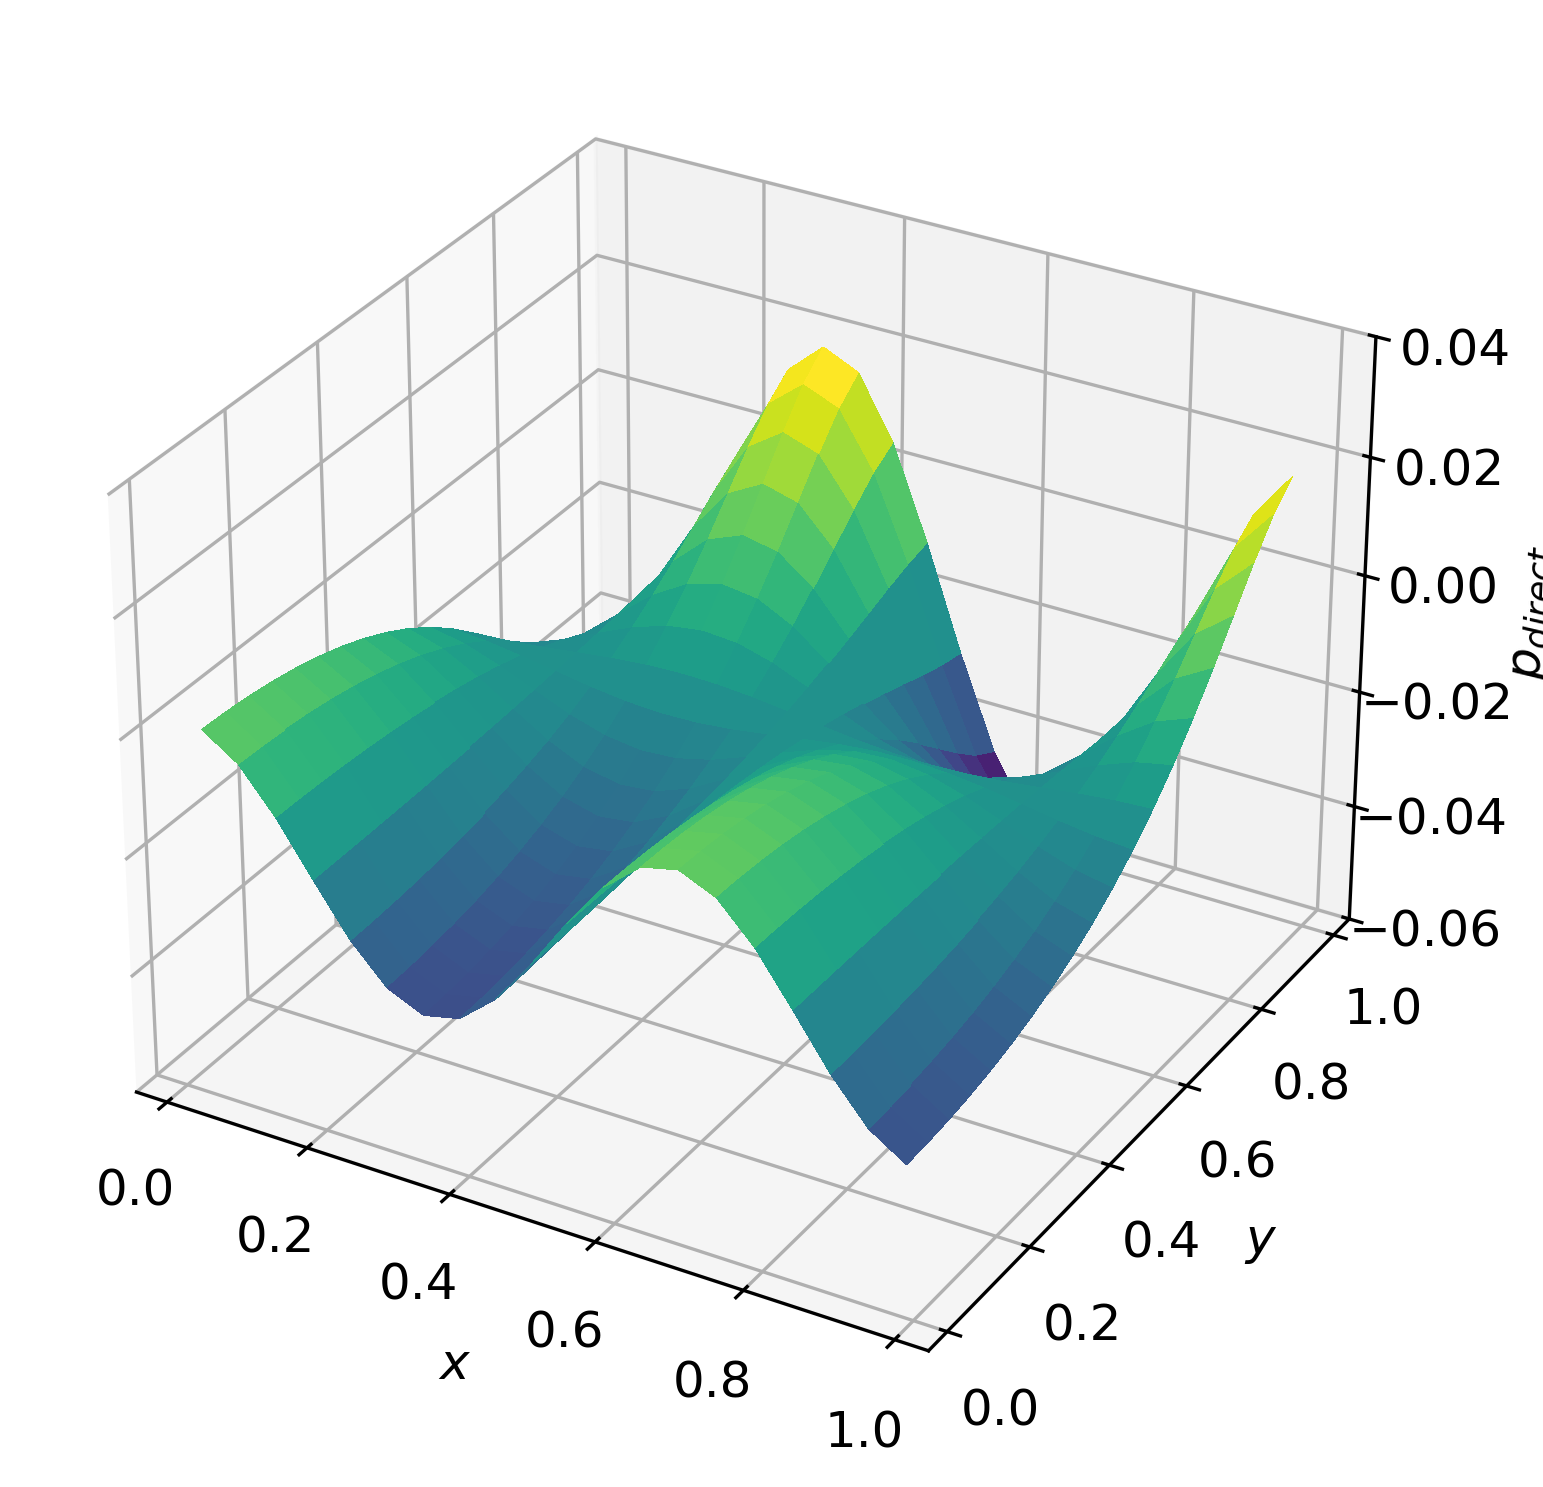

In [6]:
# Assemble laplacian matrix
L = Lapl(Nx, Ny, hx, hy)

# Set one Dirichlet value to fix pressure in one point
L[0,:] = np.zeros((1, np.size(L,axis=1))) # p_direct[0] won't change
f[0] = 0 # forcing on first point is zero
L[0,0] = -1 # correct so that matrix is not singular, ie det(L)=/=0 (i don't think this number matters since forcing is zero on the point)

# Solve the problem with a direct method
p_direct = np.linalg.inv(L).dot(f)
p_direct_shaped = p_direct.reshape((Ny, Nx)) # Reshape the solution to match the dimensions of X and Y

# plot p_direct
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, p_direct_shaped,
                       linewidth=0, antialiased=False, cmap='viridis')

ax.set(xlabel='$x$',ylabel='$y$', zlabel='$p_{direct}$')
ax.set(zlim=[-0.06, 0.04])

fig.tight_layout()

Iterative solution

In [ ]:
# Part C
# Set up the initial guess
# p0 = np.zeros((Nx+1)*(Ny+1)) # buffer on outside
p0 = np.zeros((Nx*Ny,1)) # only include inner points

# Set up the tolerance and maximum number of iterations
tol   = 10**-6
maxit = 10000

# Compute the GS iterative solution
[p, r] = GS_SOR(omega, Nx, Ny, hx, hy, L, f, p0, tol, maxit)

KeyboardInterrupt: 

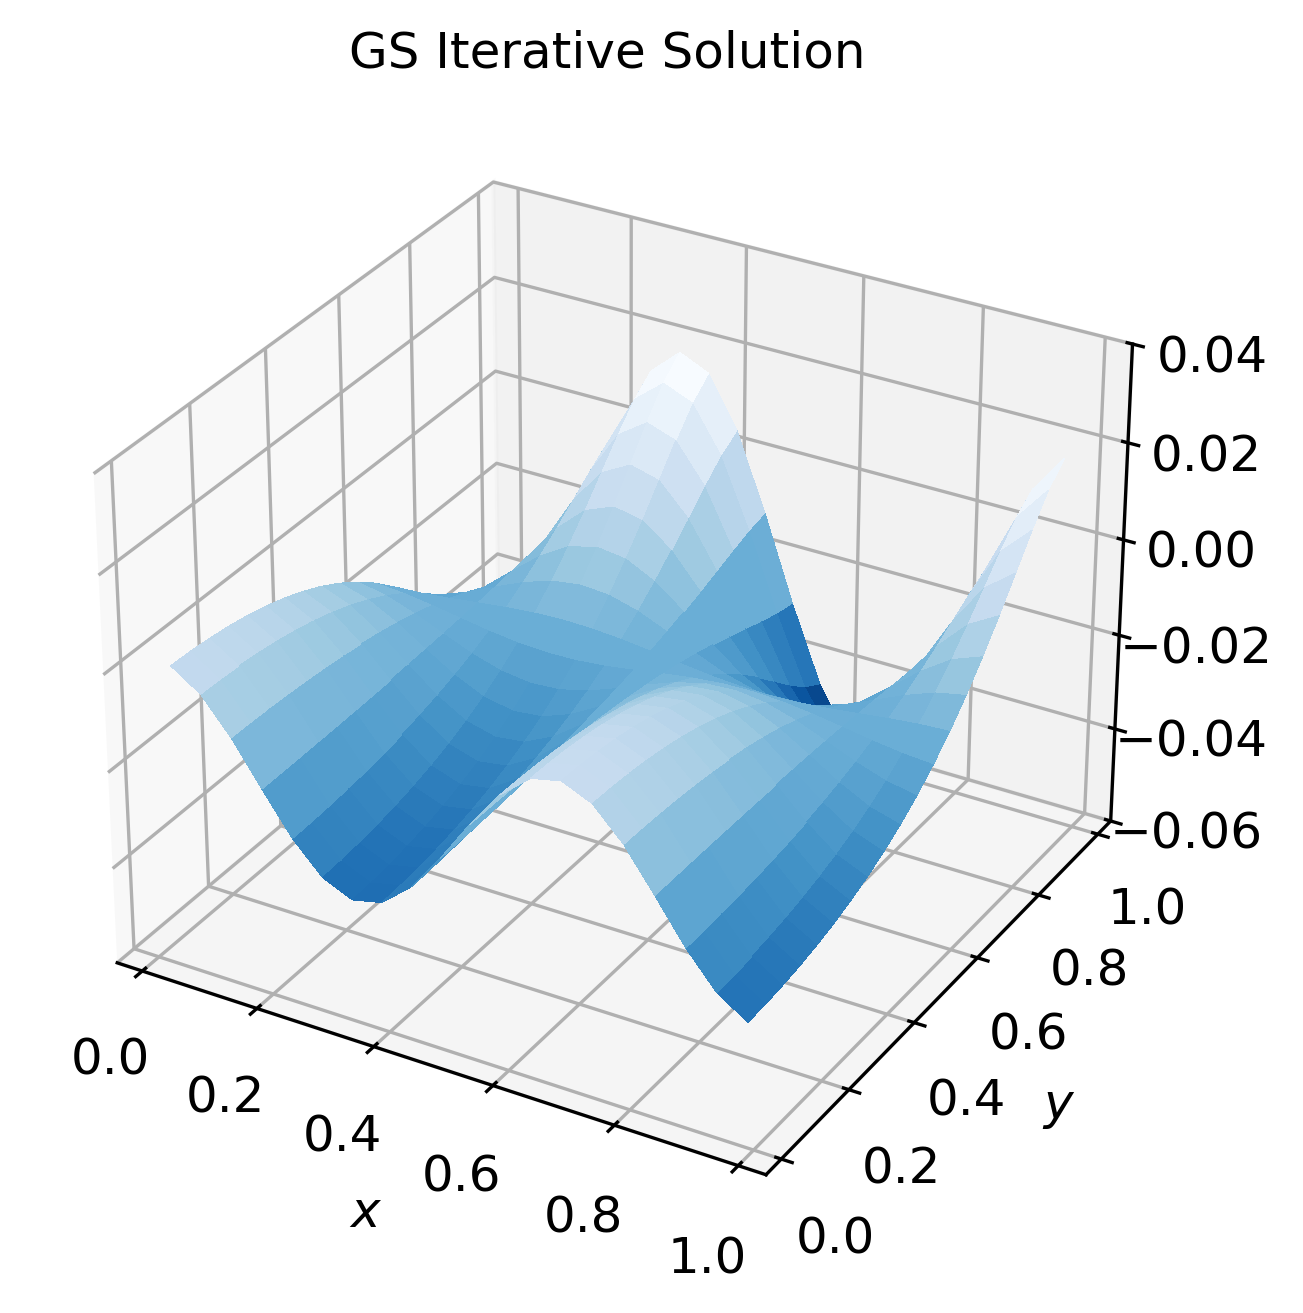

In [ ]:
# Plot the GS surface.
fig_GS, ax_GS = plt.subplots(subplot_kw={"projection": "3d"})
ax_GS.set_title('GS Iterative Solution')
ax_GS.set(xlabel='$x$',ylabel='$y$')
ax_GS.set(zlim=[-0.06, 0.04])
ax_GS.plot_surface(X,Y,p.reshape((Ny, Nx)), linewidth=0, antialiased=False, cmap='Blues_r')

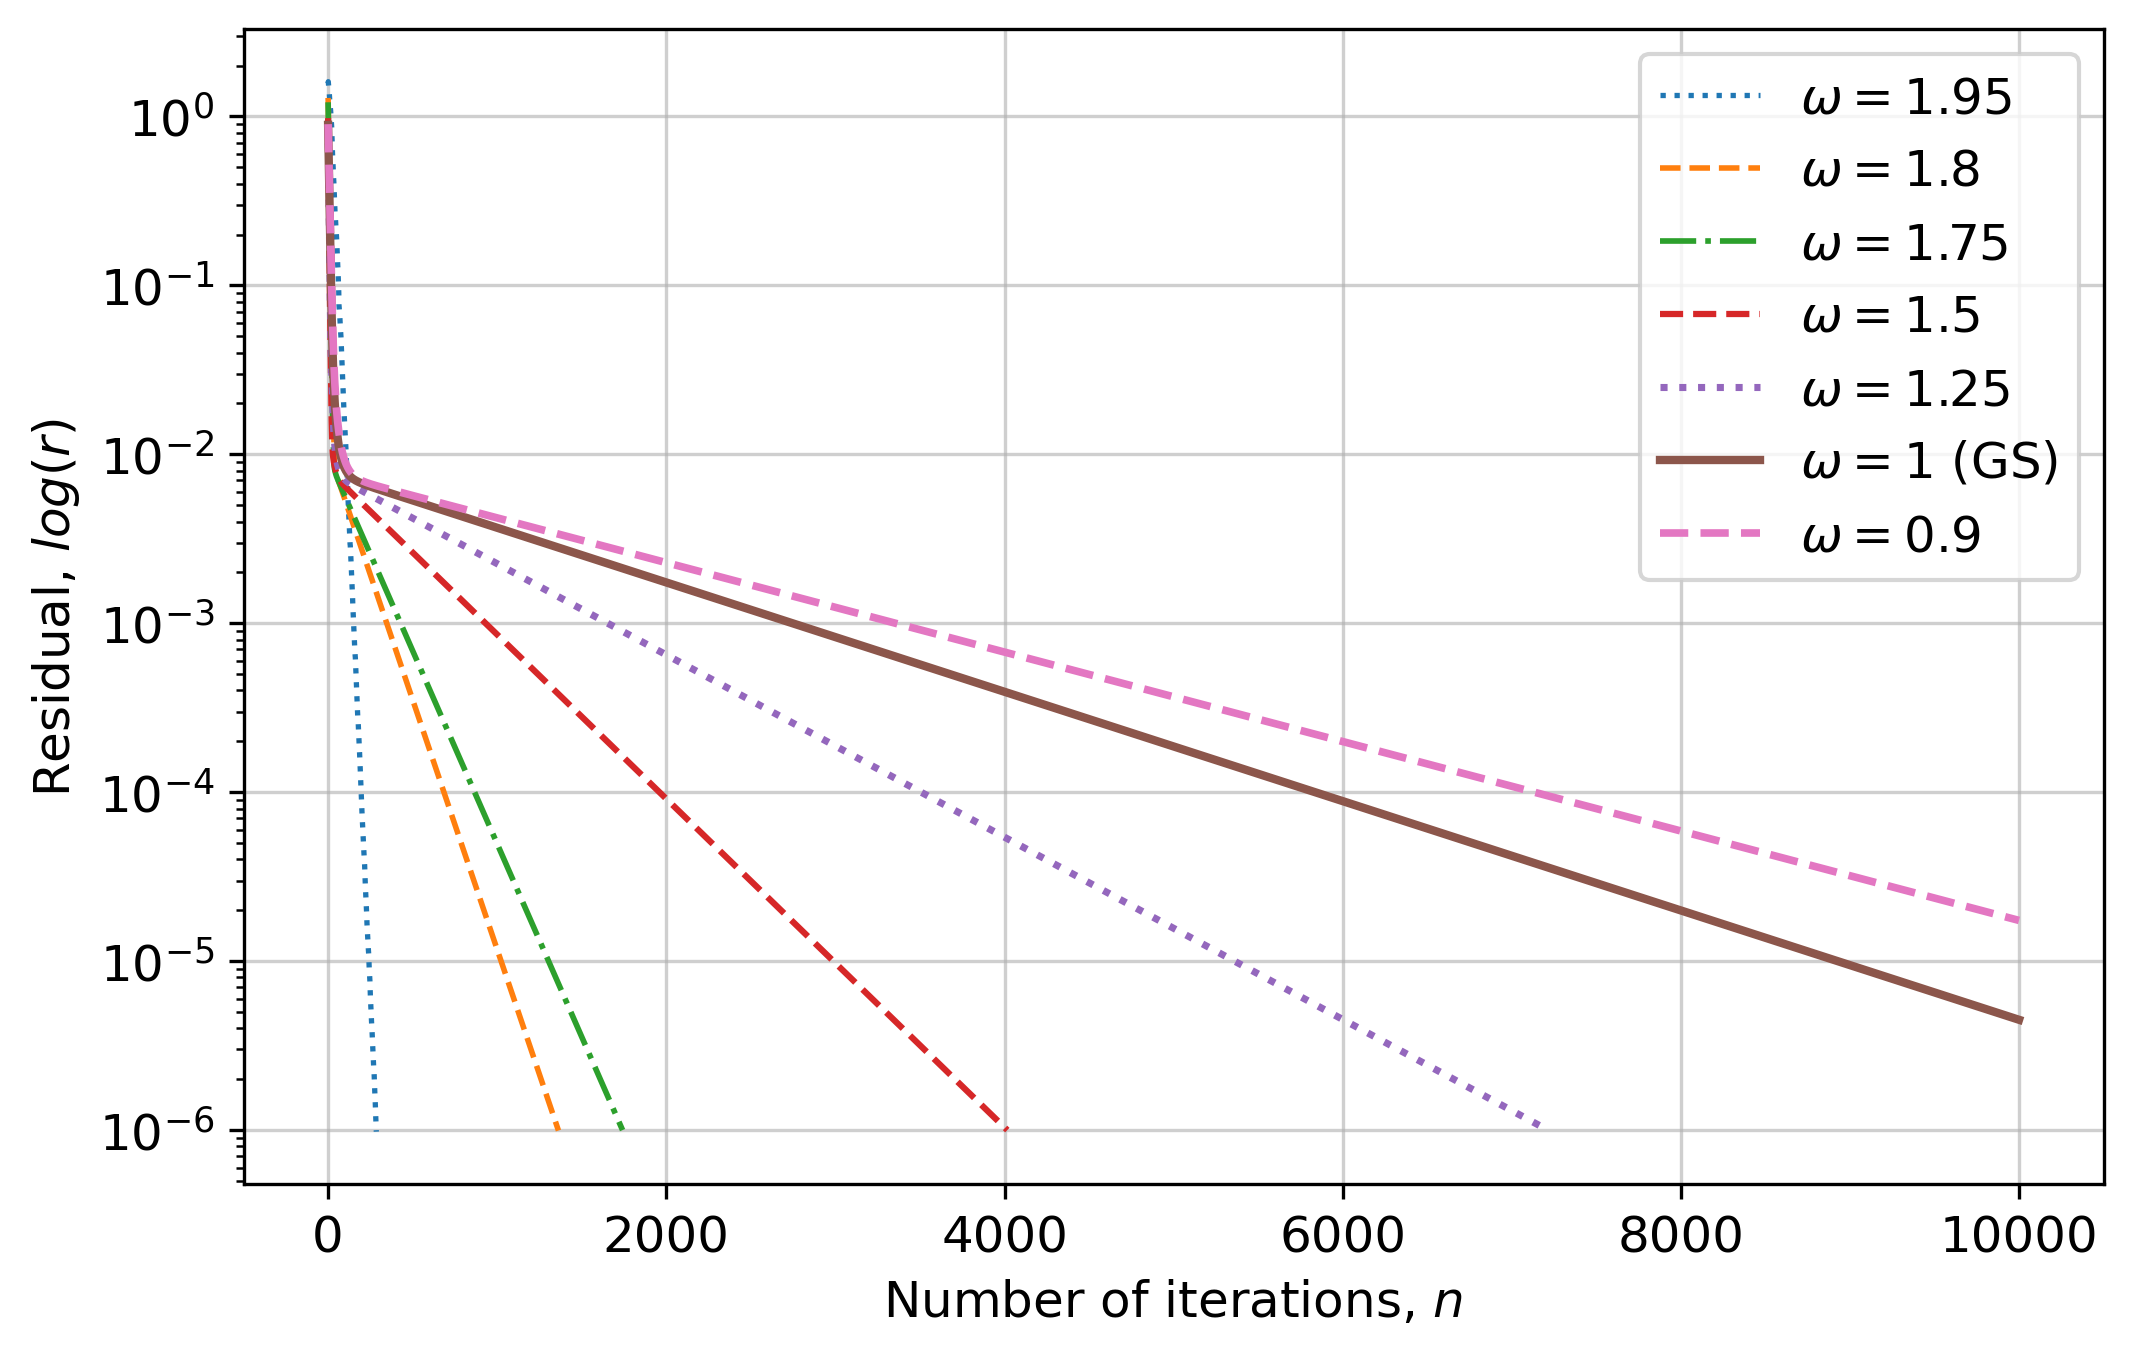

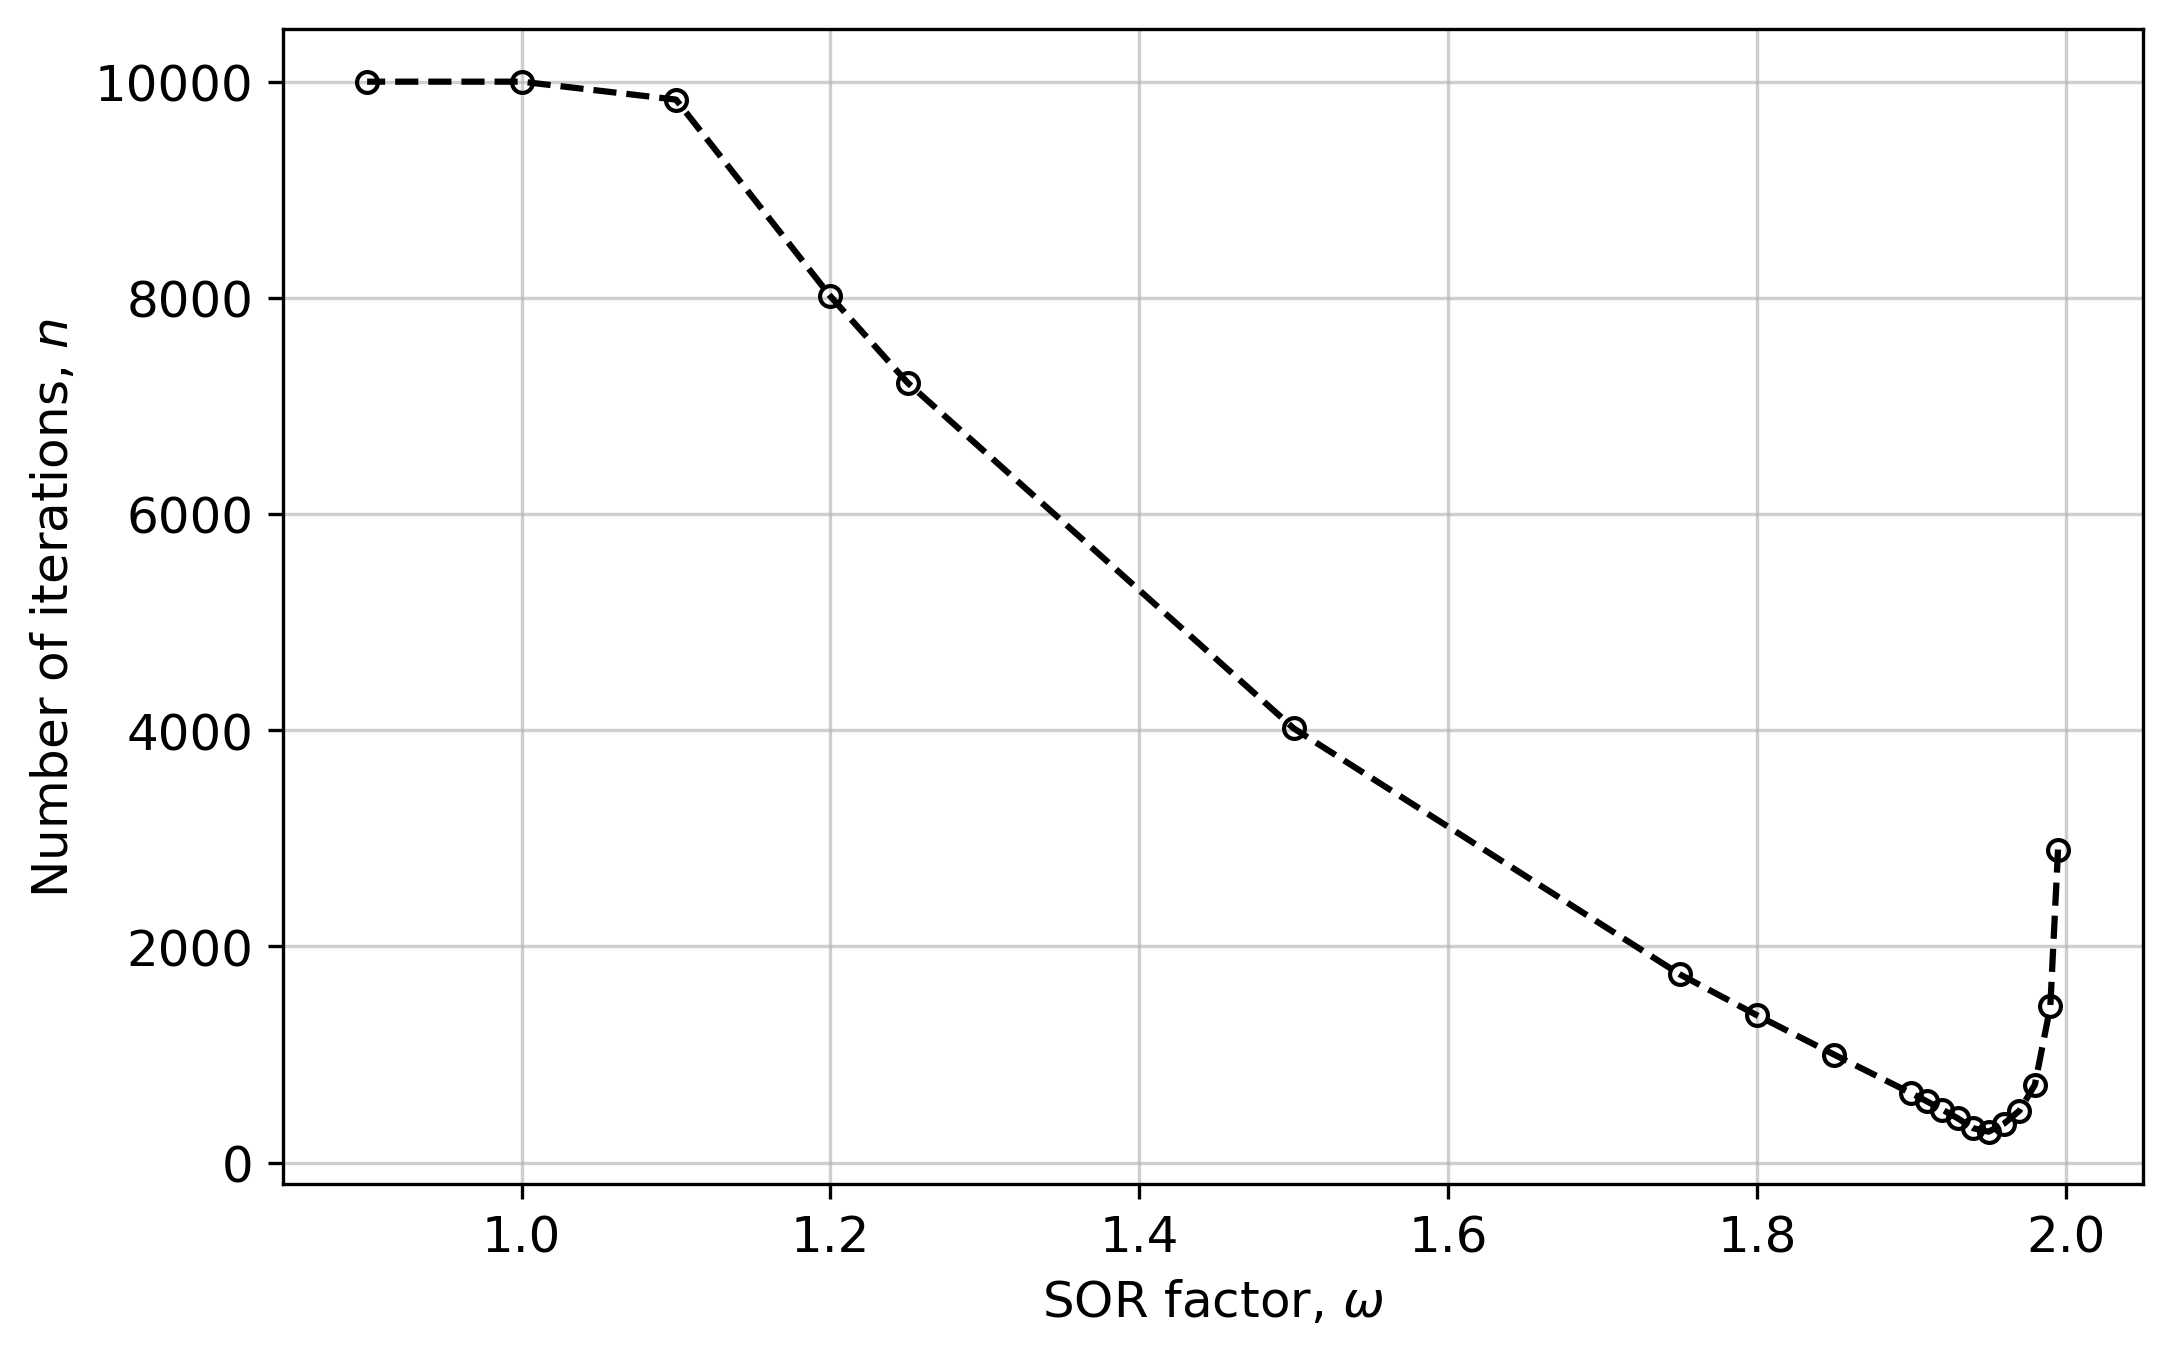

In [ ]:
# Run and plot SOR for different omegas

# Plot the residual for GS
fig_r, ax_r = plt.subplots()
# ax_r.set_title(f'Residuals for variations of SOR Method')
ax_r.set_xlabel('Number of iterations, $n$')
ax_r.set_ylabel('Residual, $log(r)$')
ax_r.grid(True)

# Loop over new omegas
omega_list = [1.995, 1.99, 1.98, 1.97, 1.96, 1.95, 1.94, 1.93, 1.92, 1.91, 1.9, 1.85, 1.8, 1.75, 1.5, 1.25, 1.2, 1.1, 1, 0.9]
plot_list = [1.95, 1.8, 1.75, 1.5, 1.25, 1, 0.9]
style_list = ['dotted', 'dashed', 'dashdot', 'dashed', 'dotted', 'solid', 'dashed']
n_list = np.ndarray((len(omega_list), 1)) # Create array to store number of iterations
for i in range(len(omega_list)):
    w = omega_list[i]
    [p_loop, r_loop] = GS_SOR(w, Nx, Ny, hx, hy, L, f, p0, tol, maxit)
    n_list[i] = len(r_loop)+1 # Extra 1 because we ignore the first element in r in the GS_SOR() function
    if w in plot_list:
        width = 2 - 1.5*np.abs(w-1)/w
        ax_r.semilogy(r_loop, label=f'$ω=${w} {'(GS)'if w==1 else ''}', linewidth=width, linestyle=style_list[plot_list.index(w)])
    

ax_r.legend()
plt.show()

# Plot iterations vs. omega
fig_nw, ax_nw = plt.subplots()
# ax_nw.set_title(f'Required Number of Iterations to Reach Tolerance of {np.format_float_scientific(tol, 0)}')
ax_nw.set_ylabel('Number of iterations, $n$')
ax_nw.set_xlabel('SOR factor, $ω$')
ax_nw.plot(omega_list, n_list, linestyle='dashed', marker='o', color='black', markersize=5)
ax_nw.grid(True)

20


KeyboardInterrupt: 

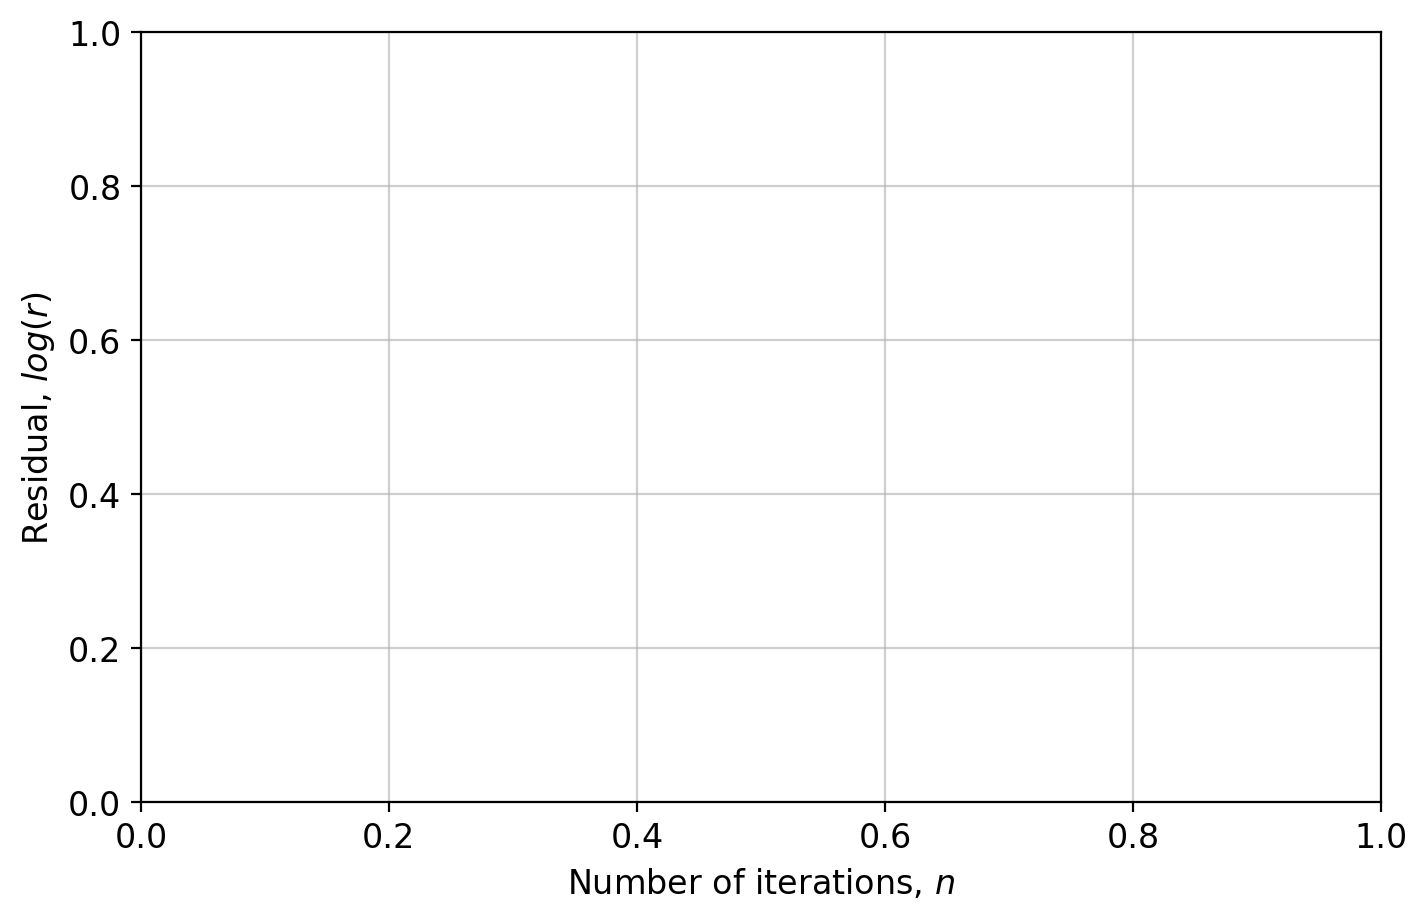

In [ ]:
# Part D: Now loop over varying N for GS method

# Plot the residual for GS
fig_N, ax_N = plt.subplots()
# ax_r.set_title(f'Residuals for variations of SOR Method')
ax_N.set_xlabel('Number of iterations, $n$')
ax_N.set_ylabel('Residual, $log(r)$')
ax_N.grid(True)

# Object to store loop results
loop_output = {}

# Loop over new omegas
N_list = [20,30,40,50,60,70,80,90,100] # 
plot_list = N_list
n_list = np.ndarray((len(N_list), 1)) # Create array to store number of iterations
for i in range(len(N_list)):
    N = N_list[i]
    print(N)
    # Copy from previous code
    p0 = np.zeros((N*N,1))
    hx = Lx/N; hy = Ly/N
    x = np.linspace(0,Lx,N+1)
    y = np.linspace(0,Ly,N+1)
    X = (x[:-1] + x[1:])/2
    Y = (y[:-1] + y[1:])/2
    X,Y= np.meshgrid(X,Y) # They remain as 2d matrices to allow easier plotting of the surface
    L = Lapl(N, N, hx, hy)
    L[0,:] = np.zeros((1, np.size(L,axis=1)))
    L[0,0] = -1
    f = np.cos(3*np.pi*X) * (np.exp(Y*Y)+2*Y*Y*np.exp(Y*Y)-np.e)
    f = f.reshape((-1, 1))
    f[0] = 0
    tol = 10**-6
    maxit=5000
    [p_loop, r_loop] = GS_SOR(1, N, N, hx, hy, L, f, p0, tol, maxit)
    loop_output[N] = {'p': p_loop, 'r': r_loop}
    print(f' - took {len(r_loop)} iterations')
    n_list[i] = len(r_loop)
    # if N in plot_list:
    ax_N.semilogy(r_loop, label=f'$N=${N}')

    # plt.show()
    

ax_N.legend()
plt.show()

# # Plot iterations vs. omega
# fig_nN, ax_nN = plt.subplots()
# # ax_nw.set_title(f'Required Number of Iterations to Reach Tolerance of {np.format_float_scientific(tol, 0)}')
# ax_nN.set_ylabel('Number of iterations, $n$')
# ax_nN.set_xlabel('SOR factor, $ω$')
# ax_nN.plot(N_list, n_list, linestyle='dashed', marker='o', color='black', markersize=5)
# ax_nN.grid(True)

In [ ]:
# Results

In [10]:


# Compare with GMRES
N=50
p0 = np.zeros((N*N,1))
hx = Lx/N; hy = Ly/N
x = np.linspace(0,Lx,N+1)
y = np.linspace(0,Ly,N+1)
X = (x[:-1] + x[1:])/2
Y = (y[:-1] + y[1:])/2
X,Y= np.meshgrid(X,Y) # They remain as 2d matrices to allow easier plotting of the surface
L = Lapl(N, N, hx, hy)
L[0,:] = np.zeros((1, np.size(L,axis=1)))
L[0,0] = -1
f = np.cos(3*np.pi*X) * (np.exp(Y*Y)+2*Y*Y*np.exp(Y*Y)-np.e)
f = f.reshape((-1, 1))
f[0] = 0
tol = 10**-6
maxit=10000

print('GS')
# [p_gs, r_gs] = GS_SOR(1, N, N, hx, hy, L, f, p0, tol, maxit)
print('SOR')
[p_sor, r_sor] = GS_SOR(1.9, N, N, hx, hy, L, f, p0, tol, maxit)
r_gmres = []
def callback(r):
    r_gmres.append(r)
print('GMRES')
p_gmres, exitCode = sp.linalg.gmres(L, f, rtol=tol, maxiter=maxit, restart=maxit, callback=callback, callback_type='pr_norm')

fig_gmres, ax_gmres = plt.subplots()
# ax_r.set_title(f'Residuals for variations of SOR Method')
ax_gmres.set_xlabel('Number of iterations, $n$')
ax_gmres.set_ylabel('Residual, $log(r)$')
ax_gmres.grid(True)

ax_gmres.semilogy(r_gmres, label='GMRES', linestyle='solid')
ax_gmres.semilogy(r_gs, label='GS', linestyle='dotted')
ax_gmres.semilogy(r_sor, label='SOR (ω=1.9)', linestyle='dashed')

plt.legend()
plt.show()



GS
SOR


KeyboardInterrupt: 